In [1]:
rm(list=ls())
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
exposure_name="UsualWalkingPace"
outcome_name="CvdStatus"

In [3]:
#load the covariates 
covar=read.table("mr_covariates.euro.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
covar$IID=NULL
covar$Sex=factor(covar$Sex)
covar$f.batch=NULL


icd=read.table("primary_cause_of_death_collapsed.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
icd$IID=NULL
icd$UnderlyingPrimaryCauseOfDeath=factor(icd$UnderlyingPrimaryCauseOfDeath)
#add in column for major cause of death 
data=inner_join(covar,icd,by="FID")


In [4]:
# add in age^2 as a covariate 
ages=read.table("ages_recruitment_death.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
ages$AgeSquared=ages$AgeAtRecruitment^2

In [5]:
#calculate time to death
ages$time_to_death=ages$AgeAtDeath-ages$AgeAtRecruitment

#or, other outcome: 
#outcome_mr=read.table("mr_outcome.txt",header=TRUE,row.names=1,sep='\t')
#outcome_v=factor(as.matrix(subset(outcome_mr,select=c(outcome_name))))
data=inner_join(data,ages,by="FID")


In [6]:
#read in the PLINK results for the exposure variable 
snps=read.table(paste("mr_snp_subsets/",exposure_name,sep=""),header=TRUE,sep='\t')
snps[snps==-1]=NA
names(snps)[1]="FID"

In [8]:
#get exposure values 
exposure_mr=read.table("mr_exposures.txt",header=TRUE,sep='\t')
names(exposure_mr)[1]="FID"
exposure_mr=subset(exposure_mr,select=c("FID","UsualWalkingPace.BriskVsOther","UsualWalkingPace.SlowVsOther"))
exposure_mr$UsualWalkingPace.BriskVsOther=factor(exposure_mr$UsualWalkingPace.BriskVsOther)
exposure_mr$UsualWalkingPace.SlowVsOther=factor(exposure_mr$UsualWalkingPace.SlowVsOther)

In [9]:
data=inner_join(data,snps,by="FID")

In [10]:
data=inner_join(data,exposure_mr,by="FID")

In [11]:
#Clean up (remove fields not needed for Cox regression)
data$IID=NULL 
data$YearOfBirth=NULL
data$AgeAtDeath=NULL
data$FID=NULL

In [12]:
#censor the subjects who are still alive 
data$status=1 
data$status[is.na(data$time_to_death)]=0

In [15]:
head(data)

Sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,AgeAtRecruitment,AgeSquared,time_to_death,rs570777080,rs554771783,rs188521060,rs2775421,UsualWalkingPace.BriskVsOther,UsualWalkingPace.SlowVsOther,status
0,0.000098641,8.37416e-05,-0.00117254,0.000546942,0.001284070,0.002849690,0.000991806,0.001610640,2.94963e-04,⋯,70,4900,NA,0,0,0,1,1,1,0
1,0.000165284,-1.74393e-03,-0.00128201,-0.001167590,0.000114421,-0.000426776,-0.000514346,0.000754035,7.04738e-04,⋯,43,1849,NA,1,0,0,NA,1,1,0
1,-0.001150320,2.59310e-03,-0.00102302,0.001088750,0.000652283,0.001128640,0.000320505,0.001577040,-3.62959e-03,⋯,53,2809,NA,1,0,0,NA,1,2,0
1,-0.000301001,-4.84239e-04,0.00105944,-0.002191060,0.001082250,-0.001773900,-0.001607440,-0.001415470,9.47541e-04,⋯,58,3364,NA,2,0,0,NA,2,1,0
1,-0.001632870,-4.77821e-04,0.00103906,0.001274720,-0.002076400,-0.001697290,0.001353240,-0.001149060,2.41438e-05,⋯,63,3969,NA,NA,0,0,NA,1,2,0
0,0.002497990,-2.32333e-04,-0.00137302,0.000604198,-0.001654240,-0.000346408,0.001155690,-0.001111370,1.74310e-03,⋯,62,3844,NA,0,0,0,1,2,1,0


In [14]:
#Perform multivariate Cox Regression

#load the necessary packages 
library(survival)
library(ranger)
library(ggplot2)
library(ggfortify)


## Brisk Vs Other

In [16]:
#fit Cox proportional hazards model that makes use of all covariates in dataset 
cox <- coxph(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             UsualWalkingPace.BriskVsOther,
             data = data)


In [17]:
summary(cox)

Call:
coxph(formula = Surv(time_to_death, status) ~ Sex + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + UnderlyingPrimaryCauseOfDeath + 
    AgeAtRecruitment + AgeSquared + UsualWalkingPace.BriskVsOther, 
    data = data)

  n= 12351, number of events= 12351 
   (425988 observations deleted due to missingness)

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
Sex1                            3.623e-02  1.037e+00  1.878e-02  1.930 0.053664
PC1                             6.787e-01  1.971e+00  6.129e+00  0.111 0.911825
PC2                             4.085e-01  1.505e+00  6.109e+00  0.067 0.946686
PC3                             2.917e+00  1.848e+01  6.171e+00  0.473 0.636483
PC4                             1.389e+01  1.077e+06  6.151e+00  2.258 0.023948
PC5                             1.094e+01  5.648e+04  6.067e+00  1.803 0.071315
PC6                             3.562e+00  3.523e+01  6.107e+00  0.583 0.559748
PC7                        

In [18]:
cox_fit <- survfit(cox)


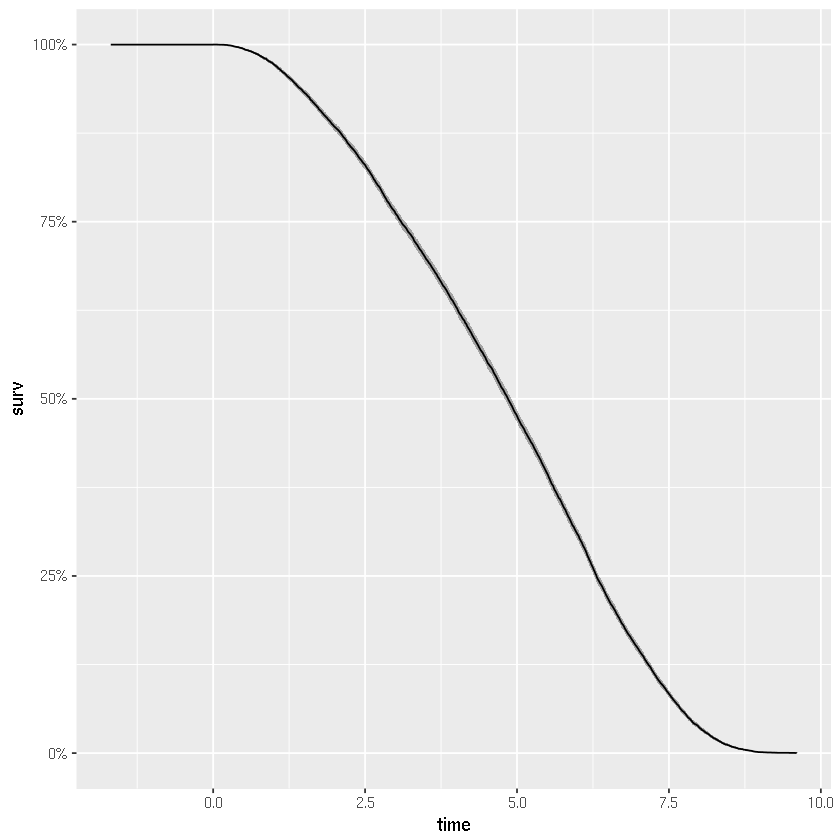

In [19]:
autoplot(cox_fit)


In [20]:
aa_fit <- aareg(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             UsualWalkingPace.BriskVsOther,
             data = data)


In [21]:
png("aa_fit_usual_walking_pace_brisk_vs_other.png",height=20,width=20,units = "in",res=300)
autoplot(aa_fit)
dev.off()


Warning message:
“Removed 2014 rows containing missing values (geom_path).”

png 
  2

![aa_fit](aa_fit_usual_walking_pace_brisk_vs_other.png)

In [26]:
#remove exposure value and re-run proportional hazards model 
cox2 <- coxph(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared,
             data = data)


In [27]:
summary(cox2)

Call:
coxph(formula = Surv(time_to_death, status) ~ Sex + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + UnderlyingPrimaryCauseOfDeath + 
    AgeAtRecruitment + AgeSquared, data = data)

  n= 12676, number of events= 12676 
   (425663 observations deleted due to missingness)

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
Sex1                            3.182e-02  1.032e+00  1.854e-02  1.717 0.085998
PC1                             7.823e-01  2.187e+00  6.055e+00  0.129 0.897195
PC2                             8.525e-01  2.345e+00  6.035e+00  0.141 0.887662
PC3                             3.000e+00  2.008e+01  6.086e+00  0.493 0.622093
PC4                             1.286e+01  3.860e+05  6.072e+00  2.119 0.034132
PC5                             1.099e+01  5.937e+04  5.986e+00  1.836 0.066319
PC6                             4.902e+00  1.346e+02  6.039e+00  0.812 0.416921
PC7                            -7.212e+00  7.374e-04  6.029e+00 

In [28]:
cox2_fit <- survfit(cox2)


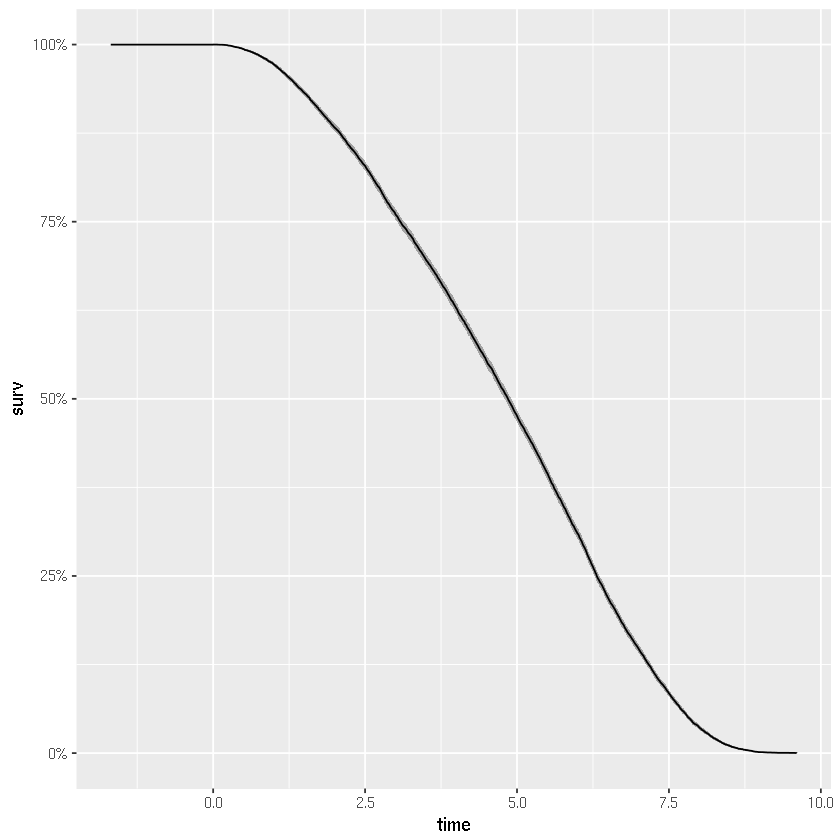

In [29]:
autoplot(cox2_fit)


## Usual Walking Pace Slow Vs Other

Call:
coxph(formula = Surv(time_to_death, status) ~ Sex + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + UnderlyingPrimaryCauseOfDeath + 
    AgeAtRecruitment + AgeSquared + UsualWalkingPace.SlowVsOther, 
    data = data)

  n= 12351, number of events= 12351 
   (425988 observations deleted due to missingness)

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
Sex1                            3.611e-02  1.037e+00  1.878e-02  1.923 0.054473
PC1                             1.083e+00  2.954e+00  6.126e+00  0.177 0.859669
PC2                             4.191e-02  1.043e+00  6.112e+00  0.007 0.994529
PC3                             3.018e+00  2.046e+01  6.170e+00  0.489 0.624715
PC4                             1.388e+01  1.067e+06  6.153e+00  2.256 0.024080
PC5                             1.105e+01  6.270e+04  6.063e+00  1.822 0.068464
PC6                             3.078e+00  2.170e+01  6.106e+00  0.504 0.614220
PC7                         

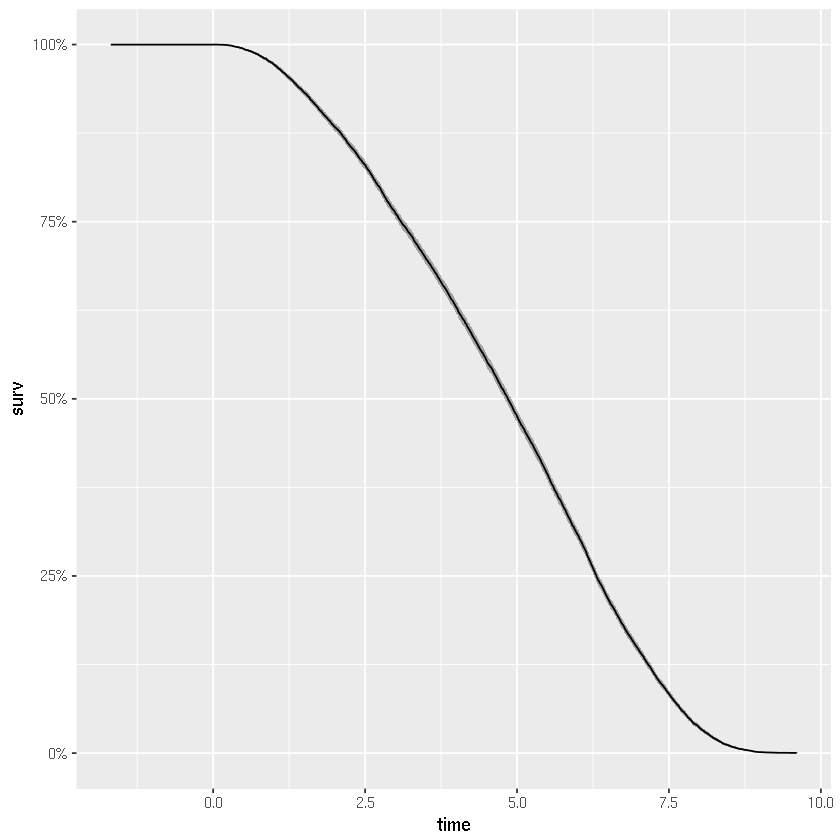

In [30]:
#fit Cox proportional hazards model that makes use of all covariates in dataset 
cox <- coxph(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             UsualWalkingPace.SlowVsOther,
             data = data)
summary(cox)
cox_fit <- survfit(cox)
autoplot(cox_fit)


In [31]:
aa_fit <- aareg(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             UsualWalkingPace.SlowVsOther,
             data = data)


In [32]:
png("aa_fit_usual_walking_pace_slow_vs_other.png",height=20,width=20,units = "in",res=300)
autoplot(aa_fit)
dev.off()


Warning message:
“Removed 1958 rows containing missing values (geom_path).”

png 
  2

![aa_fit](aa_fit_usual_walking_pace_slow_vs_other.png)